In [ ]:
pip install git+https://github.com/stefanradev93/bayesflow

Attention: Restart the runtime after installing bayesflow

# Import

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial
from scipy import stats
import pickle

import tensorflow as tf


from tqdm import tqdm
from scipy.integrate import solve_ivp
from scipy import signal
import pickle


In [3]:
import tensorflow as tf
from tensorflow_probability import distributions as tfd

#from bayesflow.amortizers import AmortizedLikelihood
#from bayesflow.networks import InvertibleNetwork
#from bayesflow.trainers import Trainer

#from utility_functions import feather_loader
import bayesflow.diagnostics as diag
from bayesflow import benchmarks
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood, AmortizedPosteriorLikelihood
from bayesflow.networks import InvertibleNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_sbc_ecdf, plot_recovery, plot_posterior_2d, plot_losses, plot_latent_space_2d

/usr/local/lib/python3.10/dist-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm






# **Generative Model Setup**

In [ ]:
def prior_sample():
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """

    N_ext = np.random.uniform(500,5500)
    D_ext = np.random.uniform(2500,3300)
    N_0 = np.random.uniform(380,4500)
    I_0 = np.random.uniform(0,1500)
    E_0 = np.random.uniform(0,10)
    D_0 = np.random.uniform(10,3000)
    params = np.array([N_ext, D_ext, N_0, I_0, E_0, D_0])
    params = np.reshape(params,(1,6))
    return np.ceil(params)

In [ ]:
def ode_system(t, y, D_ext, N_ext, p, kc, kt, gamma, gamma_I, N0, I0, E0, D0):
  N,I,E,D = y
  Nt_dt = (N0 * (1+(I**p/(I0**p+I**p)))) - (kc * N * D) - (kt * N * D_ext) - gamma * N
  It_dt = (kt * N * D_ext) - (gamma_I * I)
  Et_dt = (1 * (I**p/(I0**p+I**p))) - (gamma * E)
  Dt_dt = (D0 * (I0**p/(I0**p+I**p))) - (kc*N*D) - (kt * N_ext * D) - (gamma * D)
  return [Nt_dt, It_dt, Et_dt, Dt_dt]

In [ ]:
def Nonlinear_Solver(params, T, p = 2,
                     kc = 5.e-4,kt = 5.e-5,
                     gamma = 0.1,gamma_I = 0.5,
                     N0 = 500,I0 = 200, E0 = 1, D0 = 1000,
                     scale_I = 100, scale_N = 1000, scale_E = 0.25, scale_D = 3000):
  """Performs a forward simulation with LSODA method using solve_ivp for the Nonlinear ODE model given a random draw from the prior,"""
  # Extract parameters
  N_ext = params[0]
  D_ext = params[1]
  # Initial conditions
  initial_cond = [params[2],params[3],params[4],params[5]]
  # Simulate T+1 timesteps
  time = (0,T)
  solution = solve_ivp(ode_system,time, initial_cond, method='LSODA', args=(D_ext, N_ext, p, kc, kt, gamma, gamma_I, N0, I0, E0, D0),max_step=0.01)
  t = solution.t
  N_sol, I_sol, E_sol, D_sol = solution.y
  #return np.stack([N_sol/scale_N, I_sol/scale_I, E_sol/scale_E, D_sol/scale_D])
  return np.stack([N_sol, I_sol, E_sol, D_sol])

Time Series Simulation

In [ ]:
def sampling(input_signal, n_samples):
  n_signals = input_signal.shape[0]
  new_signal = np.zeros((n_signals,n_samples))
  for sig1, i in zip(input_signal,range(n_signals)):
    new_signal[i] = signal.resample(sig1, n_samples)
  return new_signal

In [ ]:
def simulate(N,T):
  n = Nonlinear_Solver(prior_sample()[0],T).shape[1]
  data = {}
  data['Prior'] = np.ndarray((0,6))
  data['Time_Series'] = np.ndarray((0,4,n))
  data['Sampled_Time_Series'] = np.ndarray((0,4,50))
  for i in range(N):
    prior = prior_sample()
    data['Prior'] = np.concatenate((data['Prior'], prior), axis=0)
  for p in tqdm(range(data['Prior'].shape[0])):
    TS = Nonlinear_Solver(data['Prior'][p],T)[:,0:n].reshape((1,4,n))
    data['Time_Series'] = np.concatenate((data['Time_Series'], TS), axis=0)
    s_TS = sampling(TS[0] , 50).reshape((1,4,50))
    data['Sampled_Time_Series'] = np.concatenate((data['Sampled_Time_Series'], s_TS), axis=0)
  return data

In [ ]:
T = 10
d = simulate(4,T)
#x = np.linspace(0, 1, num=T+1)
x = np.linspace(0, 1, num=50)
params = d['Prior']
sim_data = d['Sampled_Time_Series']
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
ax = ax.flat

for i, data in enumerate(sim_data):
    ax[i].plot(x, data[0])
    ax[i].plot(x, data[1])
    ax[i].plot(x, data[2])
    ax[i].plot(x, data[3])
    ax[i].set_xlabel("Time t [s]")
    ax[i].set_ylabel("Solution N,I,D,E")
    ax[i].grid(True)
    #ax[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
def data_generator(batch_size, T):

  """
  Runs the forward model 'batch_size' times by first sampling fromt the prior
  theta ~ p(theta) and running x ~ p(x|theta).
  ----------

  Arguments:
  batch_size : int -- the number of samples to draw from the prior
  ----------

  Output:
  forward_dict : dict
      The expected outputs for a BayesFlow pipeline
  """

  # Generate data
  data = simulate(batch_size,T)
  forward_dict = {"prior_draws": data['Prior'], "sim_data": np.transpose(data['Sampled_Time_Series'], axes=[0, 2, 1])}
  return forward_dict

In [ ]:
generative_model = partial(data_generator, T=10)

In [ ]:
T = 10
data = simulate(7040,T)

100%|██████████| 7040/7040 [11:33<00:00, 10.15it/s]


In [ ]:
# save dictionary to person_data.pkl file
with open('/content/drive/MyDrive/Team_Project/Simulated_Data/Time_Series_Data.pkl', 'wb') as fp:
    pickle.dump(data, fp)

# Amortizer and Trainer for N

In [27]:
# Read dictionary pkl file
with open('/Simulated_Data/Training_Test_Sets/Time_Series_Data.pkl', 'rb') as fp:
    d = pickle.load(fp)

In [28]:
mX = [6000,3500,6000,1500,10,3500]
mX = [0.1*m+m for m in mX]
mX = np.array(mX).reshape(1,6)

mY = np.array([1,4,600,1.7]).reshape(1,4,1)
normalized_dataY = (d['Time_Series'])*mY
normalized_dataX = np.divide(d['Prior'],mX)

training_data = {}
training_data['prior_draws'] = normalized_dataX[320:6720]
a = range(0,d['Time_Series'].shape[2],50)
training_data['sim_data'] = normalized_dataY[320:6720,0,a]

In [ ]:
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
#print(tf.config.list_physical_devices('GPU'))

In [29]:
# No summary net, mock
summary_net = lambda x, **kwargs: x

# Robust inference with a Student-T latent
latent_dist_p = tfd.MultivariateStudentTLinearOperator(
    df=50, loc=[0.]*6, scale=tf.linalg.LinearOperatorDiag([1.]*6))
latent_dist_l = tfd.MultivariateStudentTLinearOperator(
    df=50, loc=[0.]*21, scale=tf.linalg.LinearOperatorDiag([1.]*21))


coupling_settings = {
    'affine': {
        'dense_args': dict(units=128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        'dropout_prob': 0.05
    },
    'spline': {
        'dense_args': dict(units=128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        'dropout_prob': 0.05
    }
}

# Inference networks
inference_net_p = InvertibleNetwork(
    num_params=6,
    num_coupling_layers=6,
    coupling_design='interleaved',
    coupling_settings=coupling_settings
)

inference_net_l = InvertibleNetwork(
    num_params=21,
    num_coupling_layers=8,
    coupling_design='interleaved',
    coupling_settings=coupling_settings,
)

# Amortizers
amortized_posterior = AmortizedPosterior(
    inference_net=inference_net_p,
    summary_net=summary_net,
    latent_dist=latent_dist_p
)

amortized_likelihood = AmortizedLikelihood(
    surrogate_net=inference_net_l,
    latent_dist=latent_dist_l
)

amortizer = AmortizedPosteriorLikelihood(
    amortized_posterior,
    amortized_likelihood
)

In [30]:
def _config_posterior(forward_dict):
    """Helper function for posterior configuration."""

    input_dict = {}
    input_dict["parameters"] = forward_dict["prior_draws"].astype(np.float32)
    input_dict["direct_conditions"] = forward_dict["sim_data"].astype(np.float32)
    return input_dict


def _config_likelihood(forward_dict):
    """Helper function for likelihood configuration."""

    input_dict = {}
    input_dict["conditions"] = forward_dict["prior_draws"].astype(np.float32)
    input_dict["observables"] = forward_dict["sim_data"].astype(np.float32)
    return input_dict

def configurator(forward_dict, mode = "joint"):
    """Configures simulator outputs for use in BayesFlow training."""

    # Case only posterior configuration
    if mode == "posterior":
        input_dict = _config_posterior(forward_dict)

    # Case only plikelihood configuration
    elif mode == "likelihood":
        input_dict = _config_likelihood(forward_dict)

    # Case posterior and likelihood configuration (i.e., joint inference)
    elif mode == "joint":
        input_dict = {}
        input_dict["posterior_inputs"] = _config_posterior(forward_dict)
        input_dict["likelihood_inputs"] = _config_likelihood(forward_dict)

    # Throw otherwise
    else:
        raise NotImplementedError('For now, only a choice between ["posterior", "likelihood", "joint"] is available!')
    return input_dict

In [31]:
initial_learning_rate = 0.005

trainer = Trainer(
    amortizer=amortizer,
    default_lr=initial_learning_rate,
    checkpoint_path= "/content/drive/MyDrive/Team_Project/Checkpoint/JANA_OneSignal/",
    configurator=configurator,
)

# decay_steps = 500
num_sim = training_data['sim_data'].shape[0]
batch_size = 64
# calculate number of epochs needed to get desired number of iterations
# epochs = decay_steps // (num_sim // batch_size)

#epochs = 10

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.


Training

In [32]:
losses = trainer.train_offline(training_data, epochs=120, batch_size=batch_size)

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 101:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 102:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 103:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 104:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 105:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 106:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 107:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 108:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 109:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 110:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 111:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 112:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 113:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 114:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 115:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 116:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 117:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 118:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 119:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 120:   0%|          | 0/100 [00:00<?, ?it/s]

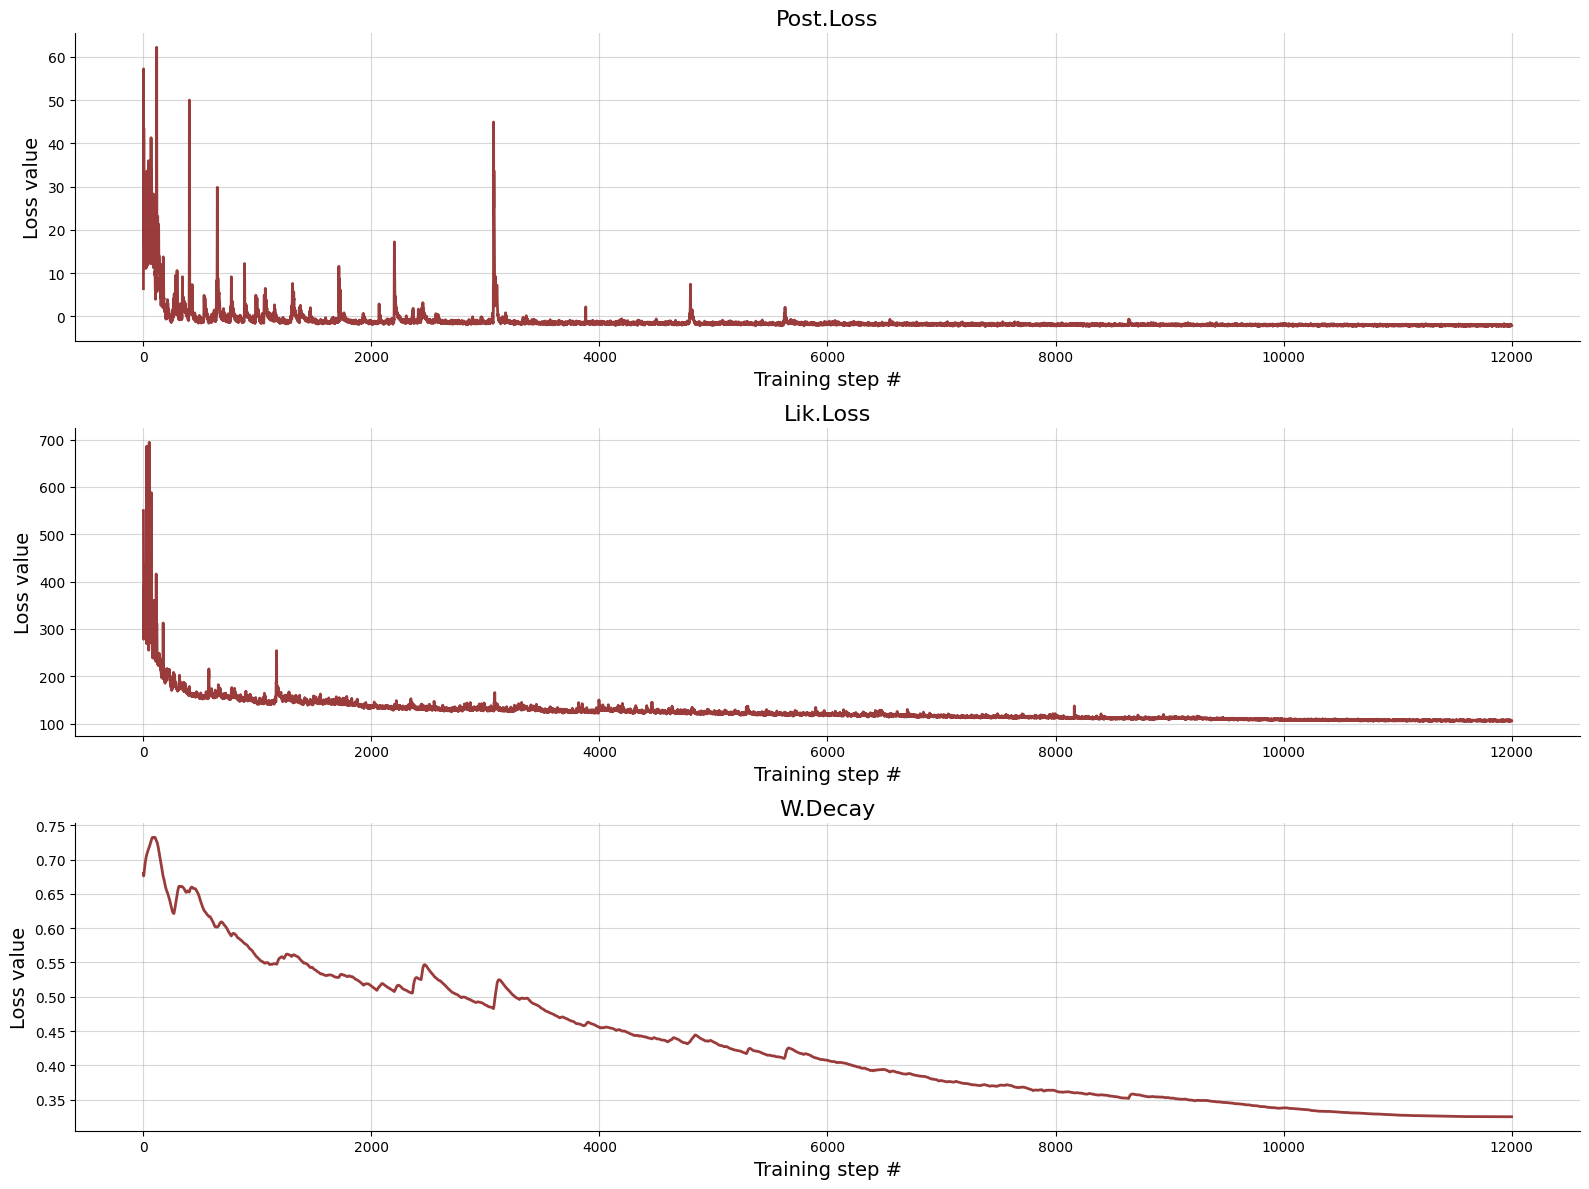

In [33]:
fig = diag.plot_losses(losses)

Validation

In [70]:
valid_data = {}
valid_data['prior_draws'] = np.concatenate((d['Prior'][0:320],d['Prior'][6720:7040]),axis = 0)
valid_data['sim_data'] = np.concatenate((d['Time_Series'][0:320,0,:],d['Time_Series'][6720:7040,0,:]), axis =0)
valid_data['Sampled'] = np.concatenate((d['Time_Series'][0:320,0,a],d['Time_Series'][6720:7040,0,a]), axis =0)

In [71]:
test_dict = {}
test_dict['conditions'] = tf.convert_to_tensor(
    np.divide(valid_data['prior_draws'], mX), dtype=float, dtype_hint=None, name=None
)
test_dict['training'] = 'False'

In [72]:
x_sim_s = amortizer.sample_data(test_dict, n_samples=50, to_numpy = True )
x_sim_s = np.squeeze(np.nanmean(x_sim_s,axis=1))
x_sim_s = np.divide(x_sim_s,mY[0,0,0])

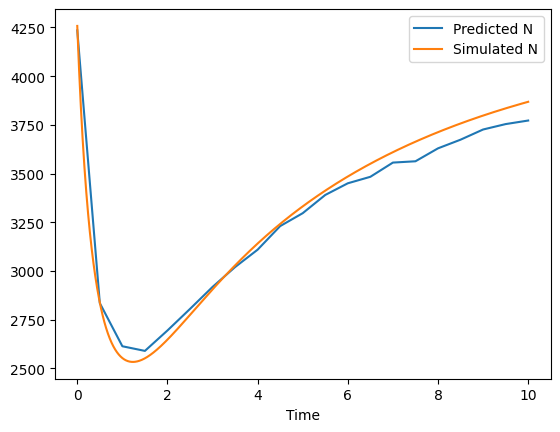

In [73]:
x1 = np.linspace(0, 10, num=1001)
x2 = np.linspace(0, 10, num=21)
plt.plot(x2,x_sim_s[95], label ="Predicted N")
plt.plot(x1,valid_data['sim_data'][95], label = "Simulated N")
#plt.plot(x2,valid_data['Sampled'][95], label = "Sampled from ODE Solution")
#plt.plot(x2,signal.medfilt(x_sim_s[2],7))
plt.xlabel("Time")
#plt.ylabel(" I ")
plt.legend()


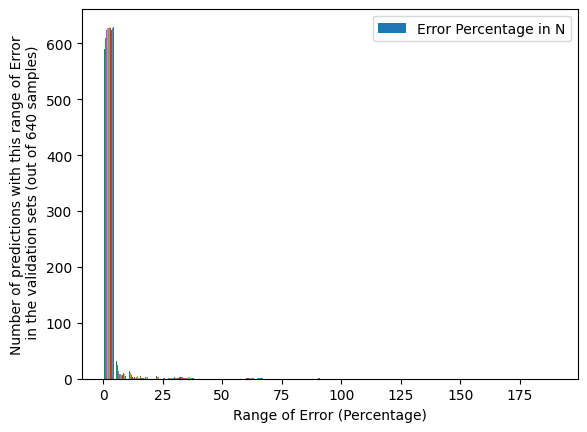

In [74]:
plt.hist((abs((abs(valid_data['Sampled'])-abs(x_sim_s))/(valid_data['Sampled']))*100),bins=[0, 5, 10, 20 , 40, 70, 100, 200],label = "Error Percentage in N")
plt.xlabel("Range of Error (Percentage)")
plt.ylabel("Number of predictions with this range of Error\n in the validation sets (out of 640 samples)")
plt.legend()

In [45]:
Accuracy_N = 1-np.nanmean(abs((abs(valid_data['Sampled'])-abs(x_sim_s))/(valid_data['Sampled'])))
print("Accuracy In N =",Accuracy_N)

print("Mean Squared Error In N", mean_squared_error(valid_data['Sampled'],x_sim_s))

Accuracy In N = 0.9878871605113654
Mean Squared Error In N 1785.4611901737696


# Amortizer and Trainer for I


In [ ]:
# Read dictionary pkl file
with open('/Simulated_Data/Training_Test_Sets/Time_Series_Data.pkl', 'rb') as fp:
    d = pickle.load(fp)

In [46]:
mX = [6000,3500,6000,1500,10,3500]
mX = [0.1*m+m for m in mX]
mX = np.array(mX).reshape(1,6)

mY = np.array([1,4,600,1.7]).reshape(1,4,1)
normalized_dataY = (d['Time_Series'])*mY
normalized_dataX = np.divide(d['Prior'],mX)

training_data = {}
training_data['prior_draws'] = normalized_dataX[320:6720]
a = range(0,d['Time_Series'].shape[2],50)
training_data['sim_data'] = normalized_dataY[320:6720,1,a]

In [ ]:
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
#print(tf.config.list_physical_devices('GPU'))

In [48]:
# No summary net, mock
summary_net = lambda x, **kwargs: x

# Robust inference with a Student-T latent
latent_dist_p = tfd.MultivariateStudentTLinearOperator(
    df=50, loc=[0.]*6, scale=tf.linalg.LinearOperatorDiag([1.]*6))
latent_dist_l = tfd.MultivariateStudentTLinearOperator(
    df=50, loc=[0.]*21, scale=tf.linalg.LinearOperatorDiag([1.]*21))


coupling_settings = {
    'affine': {
        'dense_args': dict(units=128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        'dropout_prob': 0.05
    },
    'spline': {
        'dense_args': dict(units=128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        'dropout_prob': 0.05
    }
}

# Inference networks
inference_net_p_I = InvertibleNetwork(
    num_params=6,
    num_coupling_layers=6,
    coupling_design='interleaved',
    coupling_settings=coupling_settings
)

inference_net_l_I = InvertibleNetwork(
    num_params=21,
    num_coupling_layers=8,
    coupling_design='interleaved',
    coupling_settings=coupling_settings,
)

# Amortizers
amortized_posterior_I = AmortizedPosterior(
    inference_net=inference_net_p_I,
    summary_net=summary_net,
    latent_dist=latent_dist_p
)

amortized_likelihood_I = AmortizedLikelihood(
    surrogate_net=inference_net_l_I,
    latent_dist=latent_dist_l
)

amortizer_I = AmortizedPosteriorLikelihood(
    amortized_posterior_I,
    amortized_likelihood_I
)

In [49]:
def _config_posterior(forward_dict):
    """Helper function for posterior configuration."""

    input_dict = {}
    input_dict["parameters"] = forward_dict["prior_draws"].astype(np.float32)
    input_dict["direct_conditions"] = forward_dict["sim_data"].astype(np.float32)
    return input_dict


def _config_likelihood(forward_dict):
    """Helper function for likelihood configuration."""

    input_dict = {}
    input_dict["conditions"] = forward_dict["prior_draws"].astype(np.float32)
    input_dict["observables"] = forward_dict["sim_data"].astype(np.float32)
    return input_dict

def configurator(forward_dict, mode = "joint"):
    """Configures simulator outputs for use in BayesFlow training."""

    # Case only posterior configuration
    if mode == "posterior":
        input_dict = _config_posterior(forward_dict)

    # Case only plikelihood configuration
    elif mode == "likelihood":
        input_dict = _config_likelihood(forward_dict)

    # Case posterior and likelihood configuration (i.e., joint inference)
    elif mode == "joint":
        input_dict = {}
        input_dict["posterior_inputs"] = _config_posterior(forward_dict)
        input_dict["likelihood_inputs"] = _config_likelihood(forward_dict)

    # Throw otherwise
    else:
        raise NotImplementedError('For now, only a choice between ["posterior", "likelihood", "joint"] is available!')
    return input_dict

In [50]:
initial_learning_rate = 0.005

trainer_I = Trainer(
    amortizer=amortizer_I,
    default_lr=initial_learning_rate,
    checkpoint_path= "/content/drive/MyDrive/Team_Project/Checkpoint/JANA_OneSignal/I/",
    configurator=configurator,
)

# decay_steps = 500
num_sim = training_data['sim_data'].shape[0]
batch_size = 64
# calculate number of epochs needed to get desired number of iterations
# epochs = decay_steps // (num_sim // batch_size)

#epochs = 10

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.


Training

In [51]:
losses = trainer_I.train_offline(training_data, epochs=120, batch_size=batch_size)

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 101:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 102:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 103:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 104:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 105:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 106:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 107:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 108:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 109:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 110:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 111:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 112:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 113:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 114:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 115:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 116:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 117:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 118:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 119:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 120:   0%|          | 0/100 [00:00<?, ?it/s]

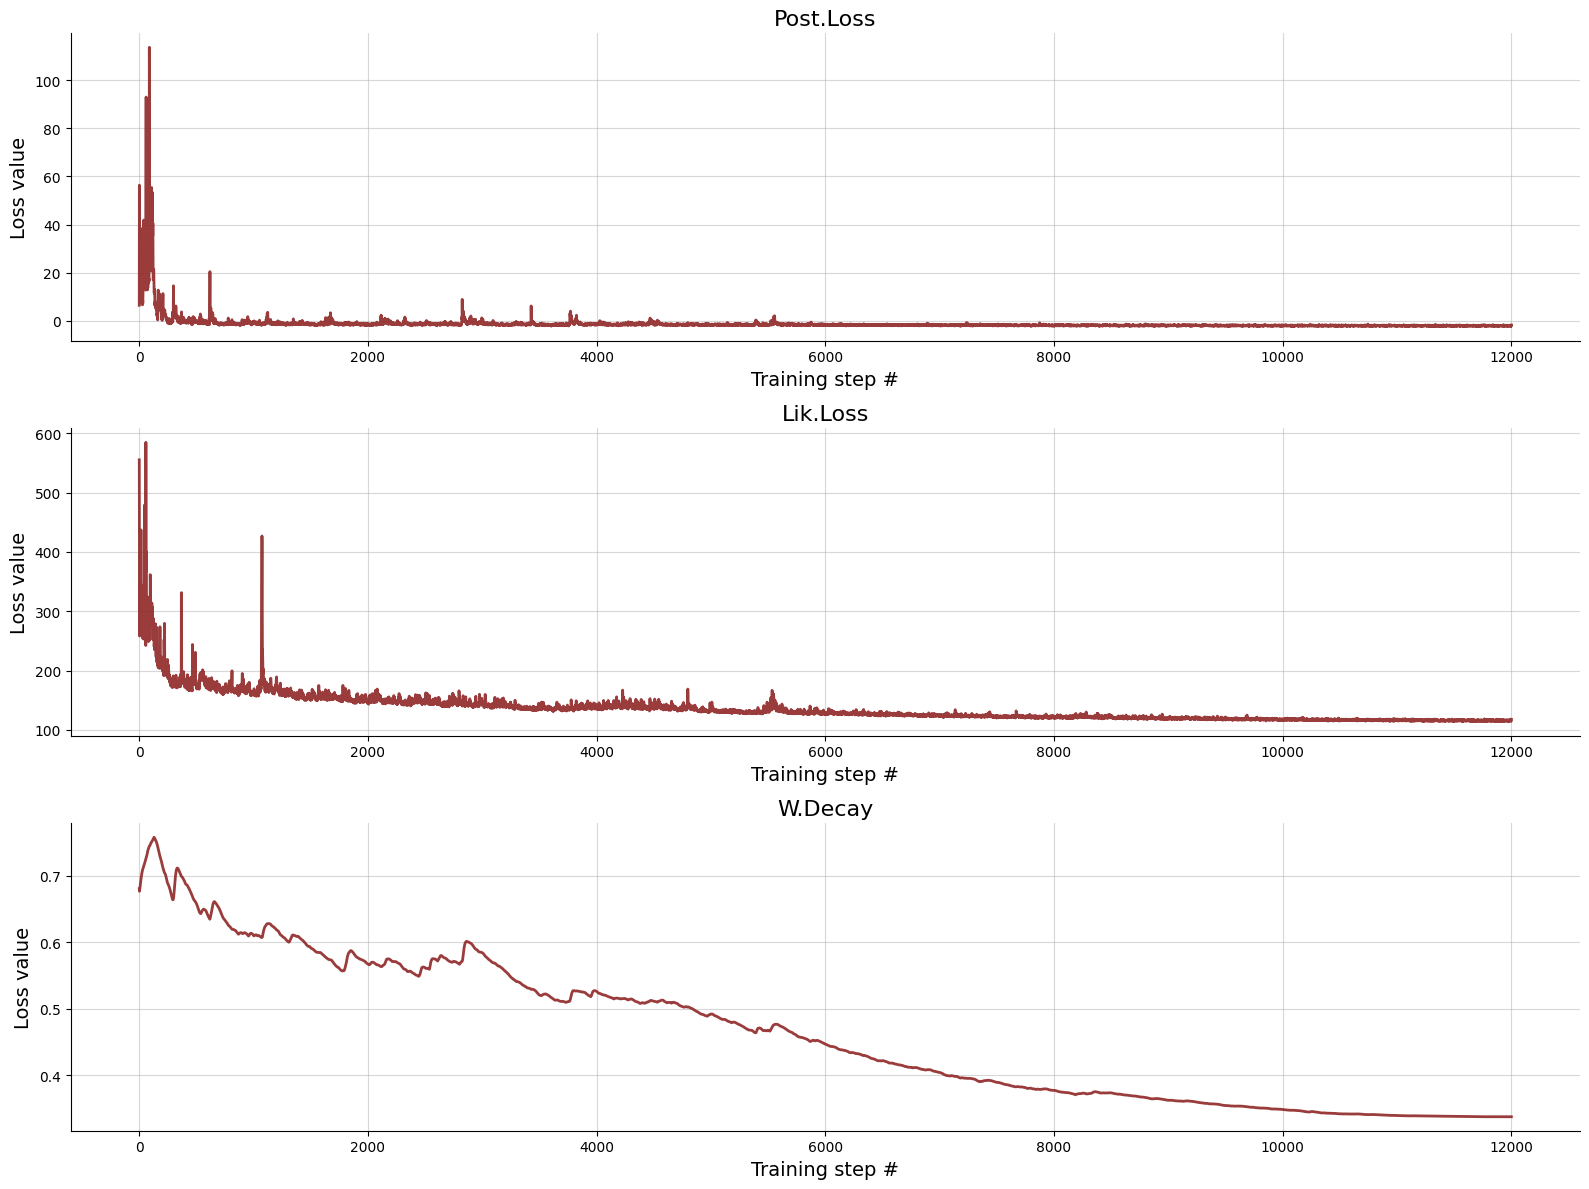

In [52]:
fig = diag.plot_losses(losses)

Validation

In [53]:
valid_data = {}
valid_data['prior_draws'] = np.concatenate((d['Prior'][0:320],d['Prior'][6720:7040]),axis = 0)
valid_data['sim_data'] = np.concatenate((d['Time_Series'][0:320,1,:],d['Time_Series'][6720:7040,1,:]), axis =0)
valid_data['Sampled'] = np.concatenate((d['Time_Series'][0:320,1,a],d['Time_Series'][6720:7040,1,a]), axis =0)

In [54]:
test_dict = {}
test_dict['conditions'] = tf.convert_to_tensor(
    np.divide(valid_data['prior_draws'],mX), dtype=float, dtype_hint=None, name=None
)
test_dict['training'] = 'False'

In [55]:
x_sim_s = amortizer_I.sample_data(test_dict, n_samples=50, to_numpy = True )
x_sim_s = np.squeeze(np.nanmean(x_sim_s,axis=1))
x_sim_s = np.divide(x_sim_s,mY[0,1,0])

In [56]:
x_sim_s.shape

(640, 21)

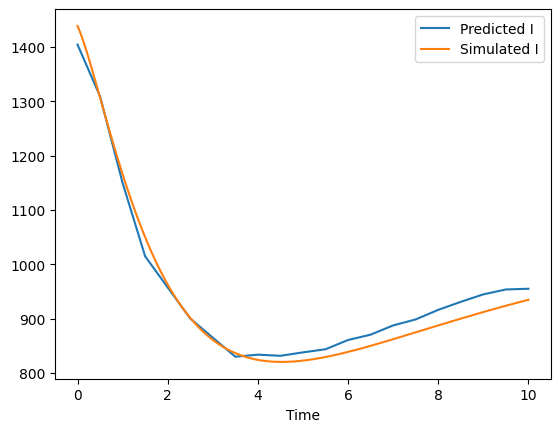

In [68]:
x1 = np.linspace(0, 10, num=1001)
x2 = np.linspace(0, 10, num=21)
plt.plot(x2,x_sim_s[95], label ="Predicted I")
plt.plot(x1,valid_data['sim_data'][95], label = "Simulated I")
#plt.plot(x2,valid_data['Sampled'][95], label = "Sampled from ODE Solution")
#plt.plot(x2,signal.medfilt(x_sim_s[2],7))
plt.xlabel("Time")
#plt.ylabel(" I ")
plt.legend()

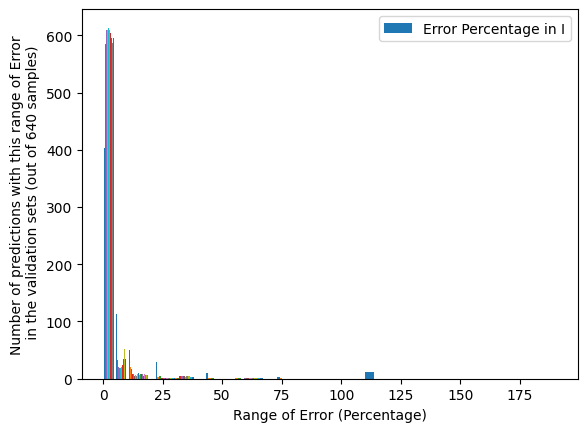

In [69]:
plt.hist((abs((abs(valid_data['Sampled'])-abs(x_sim_s))/(valid_data['Sampled']))*100),bins=[0, 5, 10, 20 , 40, 70, 100, 200],label = "Error Percentage in I")
plt.xlabel("Range of Error (Percentage)")
plt.ylabel("Number of predictions with this range of Error\n in the validation sets (out of 640 samples)")
plt.legend()

In [ ]:
Accuracy_I = 1-np.nanmean(abs((abs(valid_data['Sampled'])-abs(x_sim_s))/(valid_data['Sampled'])))
print("Accuracy In I =",Accuracy_I)

mean_squared_error(valid_data['Sampled'],x_sim_s)

Accuracy In I = 0.8158068389275148


8708.992419906608

# Amortizer and Trainer for E


In [ ]:
# Read dictionary pkl file
with open('/Simulated_Data/Time_Series_Data.pkl', 'rb') as fp:
    d = pickle.load(fp)

In [75]:
mX = [6000,3500,6000,1500,10,3500]
mX = [0.1*m+m for m in mX]
mX = np.array(mX).reshape(1,6)

mY = np.array([1,4,600,1.7]).reshape(1,4,1)
normalized_dataY = (d['Time_Series'])*mY
normalized_dataX = np.divide(d['Prior'],mX)

training_data = {}
training_data['prior_draws'] = normalized_dataX[320:6720]
a = range(0,d['Time_Series'].shape[2],50)
training_data['sim_data'] = normalized_dataY[320:6720,2,a]

In [ ]:
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
#print(tf.config.list_physical_devices('GPU'))

In [76]:
# No summary net, mock
summary_net = lambda x, **kwargs: x

# Robust inference with a Student-T latent
latent_dist_p = tfd.MultivariateStudentTLinearOperator(
    df=50, loc=[0.]*6, scale=tf.linalg.LinearOperatorDiag([1.]*6))
latent_dist_l = tfd.MultivariateStudentTLinearOperator(
    df=50, loc=[0.]*21, scale=tf.linalg.LinearOperatorDiag([1.]*21))


coupling_settings = {
    'affine': {
        'dense_args': dict(units=128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        'dropout_prob': 0.05
    },
    'spline': {
        'dense_args': dict(units=128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        'dropout_prob': 0.05
    }
}

# Inference networks
inference_net_p_E = InvertibleNetwork(
    num_params=6,
    num_coupling_layers=6,
    coupling_design='interleaved',
    coupling_settings=coupling_settings
)

inference_net_l_E = InvertibleNetwork(
    num_params=21,
    num_coupling_layers=8,
    coupling_design='interleaved',
    coupling_settings=coupling_settings,
)

# Amortizers
amortized_posterior_E = AmortizedPosterior(
    inference_net=inference_net_p_E,
    summary_net=summary_net,
    latent_dist=latent_dist_p
)

amortized_likelihood_E = AmortizedLikelihood(
    surrogate_net=inference_net_l_E,
    latent_dist=latent_dist_l
)

amortizer_E = AmortizedPosteriorLikelihood(
    amortized_posterior_E,
    amortized_likelihood_E
)

In [77]:
def _config_posterior(forward_dict):
    """Helper function for posterior configuration."""

    input_dict = {}
    input_dict["parameters"] = forward_dict["prior_draws"].astype(np.float32)
    input_dict["direct_conditions"] = forward_dict["sim_data"].astype(np.float32)
    return input_dict


def _config_likelihood(forward_dict):
    """Helper function for likelihood configuration."""

    input_dict = {}
    input_dict["conditions"] = forward_dict["prior_draws"].astype(np.float32)
    input_dict["observables"] = forward_dict["sim_data"].astype(np.float32)
    return input_dict

def configurator(forward_dict, mode = "joint"):
    """Configures simulator outputs for use in BayesFlow training."""

    # Case only posterior configuration
    if mode == "posterior":
        input_dict = _config_posterior(forward_dict)

    # Case only plikelihood configuration
    elif mode == "likelihood":
        input_dict = _config_likelihood(forward_dict)

    # Case posterior and likelihood configuration (i.e., joint inference)
    elif mode == "joint":
        input_dict = {}
        input_dict["posterior_inputs"] = _config_posterior(forward_dict)
        input_dict["likelihood_inputs"] = _config_likelihood(forward_dict)

    # Throw otherwise
    else:
        raise NotImplementedError('For now, only a choice between ["posterior", "likelihood", "joint"] is available!')
    return input_dict

In [79]:
initial_learning_rate = 0.005

trainer_E = Trainer(
    amortizer=amortizer_E,
    default_lr=initial_learning_rate,
    checkpoint_path= "/content/drive/MyDrive/Team_Project/Checkpoint/JANA_OneSignal/E/",
    configurator=configurator,
)

# decay_steps = 500
num_sim = training_data['sim_data'].shape[0]
batch_size = 64
# calculate number of epochs needed to get desired number of iterations
# epochs = decay_steps // (num_sim // batch_size)

#epochs = 10

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.


Training

In [80]:
losses = trainer_E.train_offline(training_data, epochs=120, batch_size=batch_size)

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 101:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 102:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 103:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 104:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 105:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 106:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 107:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 108:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 109:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 110:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 111:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 112:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 113:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 114:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 115:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 116:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 117:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 118:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 119:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 120:   0%|          | 0/100 [00:00<?, ?it/s]

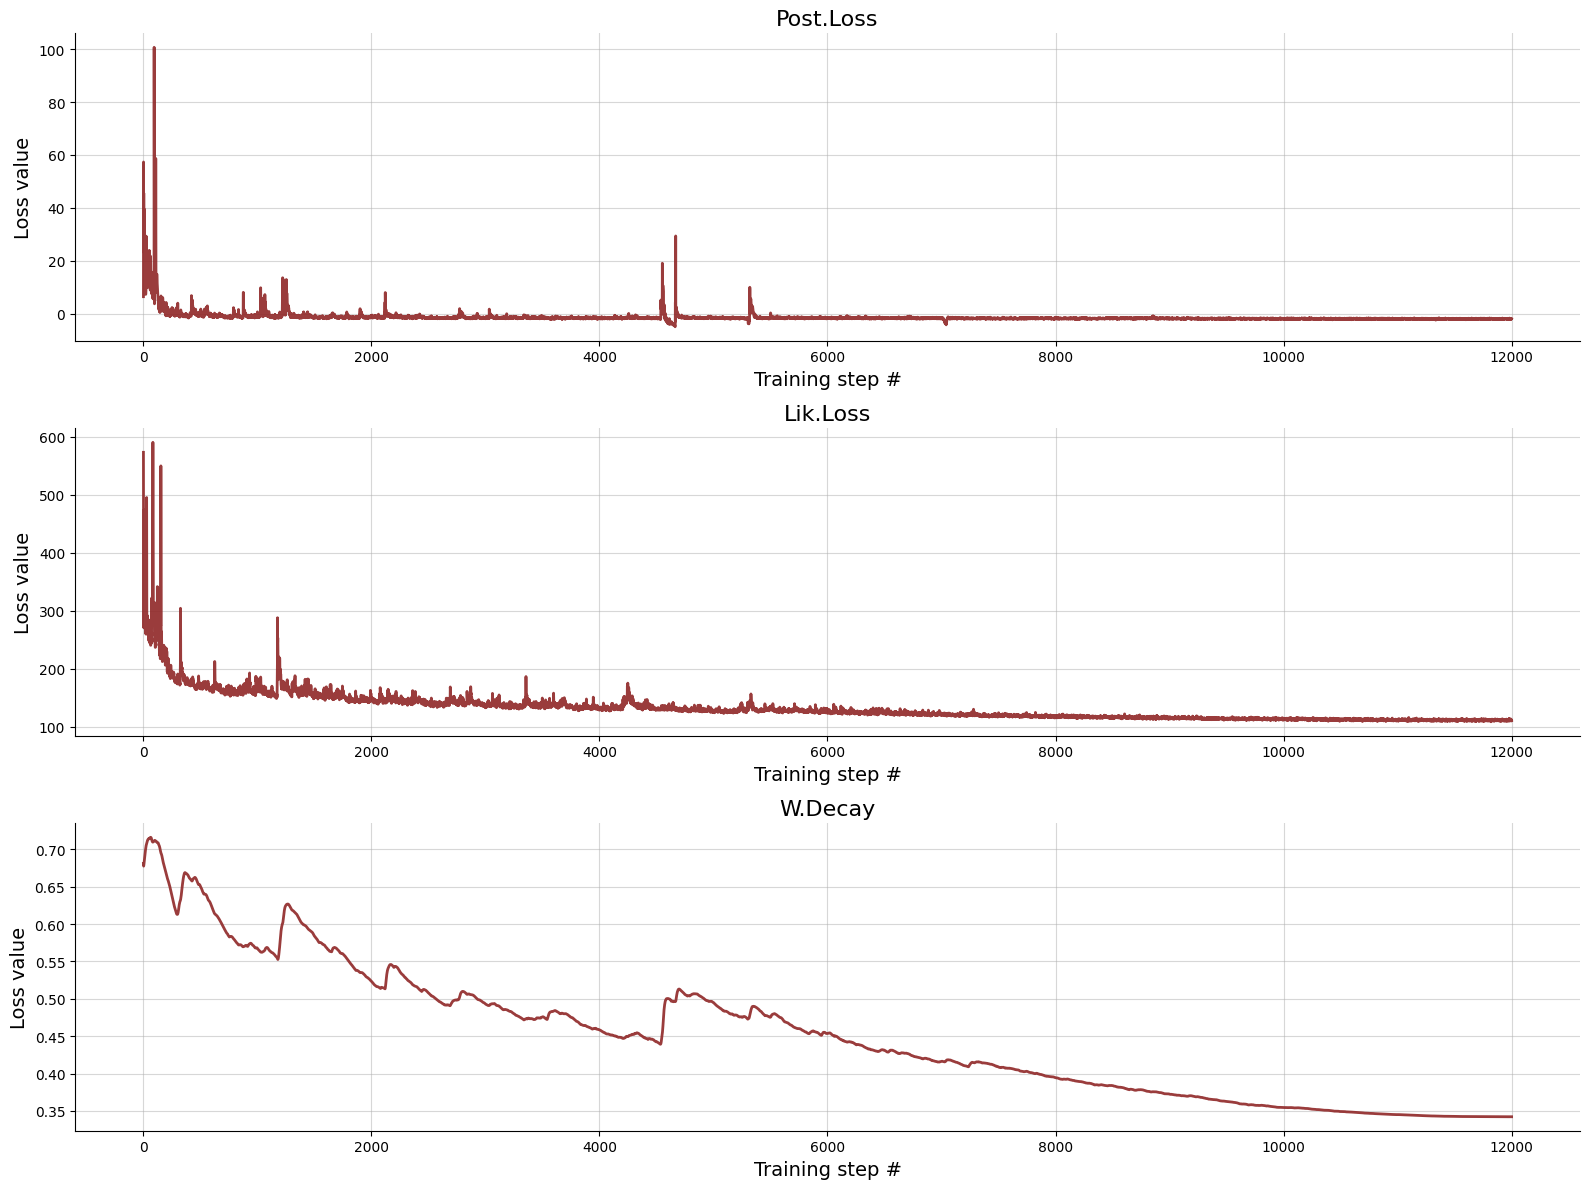

In [81]:
fig = diag.plot_losses(losses)

Validation

In [82]:
valid_data = {}
valid_data['prior_draws'] = np.concatenate((d['Prior'][0:320],d['Prior'][6720:7040]),axis = 0)
valid_data['sim_data'] = np.concatenate((d['Time_Series'][0:320,2,:],d['Time_Series'][6720:7040,2,:]), axis =0)
valid_data['Sampled'] = np.concatenate((d['Time_Series'][0:320,2,a],d['Time_Series'][6720:7040,2,a]), axis =0)

In [83]:
test_dict = {}
test_dict['conditions'] = tf.convert_to_tensor(
    np.divide(valid_data['prior_draws'],mX), dtype=float, dtype_hint=None, name=None
)
test_dict['training'] = 'False'

In [86]:
x_sim_s = amortizer_E.sample_data(test_dict, n_samples=50, to_numpy = True )
x_sim_s = np.squeeze(np.nanmean(x_sim_s,axis=1))
x_sim_s = np.divide(x_sim_s,mY[0,2,0])

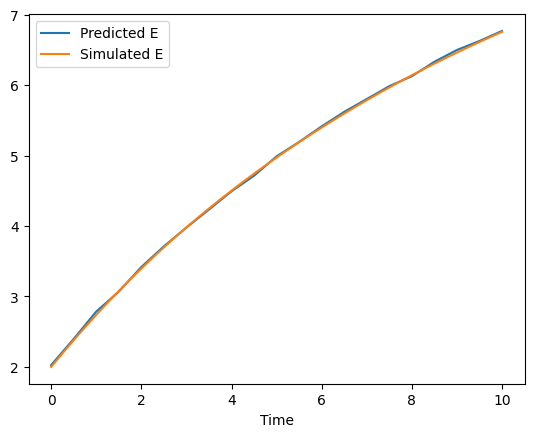

In [89]:
x1 = np.linspace(0, 10, num=1001)
x2 = np.linspace(0, 10, num=21)
plt.plot(x2,x_sim_s[95], label ="Predicted E")
plt.plot(x1,valid_data['sim_data'][95], label = "Simulated E")
#plt.plot(x2,valid_data['Sampled'][95], label = "Sampled from ODE Solution")
#plt.plot(x2,signal.medfilt(x_sim_s[2],7))
plt.xlabel("Time")
#plt.ylabel(" I ")
plt.legend()

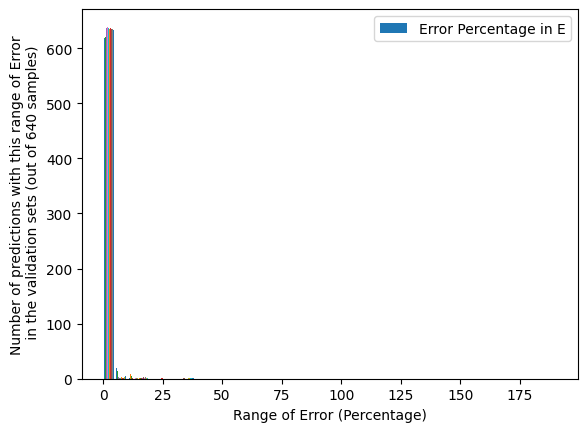

In [90]:
plt.hist((abs((abs(valid_data['Sampled'])-abs(x_sim_s))/(valid_data['Sampled']))*100),bins=[0, 5, 10, 20 , 40, 70, 100, 200],label = "Error Percentage in E")
plt.xlabel("Range of Error (Percentage)")
plt.ylabel("Number of predictions with this range of Error\n in the validation sets (out of 640 samples)")
plt.legend()

In [91]:
Accuracy_E = 1-np.nanmean(abs((abs(valid_data['Sampled'])-abs(x_sim_s))/(valid_data['Sampled'])))
print("Accuracy In E =",Accuracy_E)

mean_squared_error(valid_data['Sampled'],x_sim_s)

Accuracy In E = 0.9932670553783692


0.00444278844240638

# Amortizer and Trainer for D


In [ ]:
# Read dictionary pkl file
with open('/Simulated_Data/Time_Series_Data.pkl', 'rb') as fp:
    d = pickle.load(fp)

In [92]:
mX = [6000,3500,6000,1500,10,3500]
mX = [0.1*m+m for m in mX]
mX = np.array(mX).reshape(1,6)

mY = np.array([1,4,600,1.7]).reshape(1,4,1)
normalized_dataY = (d['Time_Series'])*mY
normalized_dataX = np.divide(d['Prior'],mX)

training_data = {}
training_data['prior_draws'] = normalized_dataX[320:6720]
a = range(0,d['Time_Series'].shape[2],50)
training_data['sim_data'] = normalized_dataY[320:6720,3,a]

In [ ]:
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
#print(tf.config.list_physical_devices('GPU'))

In [93]:
# No summary net, mock
summary_net = lambda x, **kwargs: x

# Robust inference with a Student-T latent
latent_dist_p = tfd.MultivariateStudentTLinearOperator(
    df=50, loc=[0.]*6, scale=tf.linalg.LinearOperatorDiag([1.]*6))
latent_dist_l = tfd.MultivariateStudentTLinearOperator(
    df=50, loc=[0.]*21, scale=tf.linalg.LinearOperatorDiag([1.]*21))


coupling_settings = {
    'affine': {
        'dense_args': dict(units=128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        'dropout_prob': 0.05
    },
    'spline': {
        'dense_args': dict(units=128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        'dropout_prob': 0.05
    }
}

# Inference networks
inference_net_p_D = InvertibleNetwork(
    num_params=6,
    num_coupling_layers=6,
    coupling_design='interleaved',
    coupling_settings=coupling_settings
)

inference_net_l_D = InvertibleNetwork(
    num_params=21,
    num_coupling_layers=8,
    coupling_design='interleaved',
    coupling_settings=coupling_settings,
)

# Amortizers
amortized_posterior_D = AmortizedPosterior(
    inference_net=inference_net_p_D,
    summary_net=summary_net,
    latent_dist=latent_dist_p
)

amortized_likelihood_D = AmortizedLikelihood(
    surrogate_net=inference_net_l_D,
    latent_dist=latent_dist_l
)

amortizer_D = AmortizedPosteriorLikelihood(
    amortized_posterior_D,
    amortized_likelihood_D
)

In [94]:
def _config_posterior(forward_dict):
    """Helper function for posterior configuration."""

    input_dict = {}
    input_dict["parameters"] = forward_dict["prior_draws"].astype(np.float32)
    input_dict["direct_conditions"] = forward_dict["sim_data"].astype(np.float32)
    return input_dict


def _config_likelihood(forward_dict):
    """Helper function for likelihood configuration."""

    input_dict = {}
    input_dict["conditions"] = forward_dict["prior_draws"].astype(np.float32)
    input_dict["observables"] = forward_dict["sim_data"].astype(np.float32)
    return input_dict

def configurator(forward_dict, mode = "joint"):
    """Configures simulator outputs for use in BayesFlow training."""

    # Case only posterior configuration
    if mode == "posterior":
        input_dict = _config_posterior(forward_dict)

    # Case only plikelihood configuration
    elif mode == "likelihood":
        input_dict = _config_likelihood(forward_dict)

    # Case posterior and likelihood configuration (i.e., joint inference)
    elif mode == "joint":
        input_dict = {}
        input_dict["posterior_inputs"] = _config_posterior(forward_dict)
        input_dict["likelihood_inputs"] = _config_likelihood(forward_dict)

    # Throw otherwise
    else:
        raise NotImplementedError('For now, only a choice between ["posterior", "likelihood", "joint"] is available!')
    return input_dict

In [95]:
initial_learning_rate = 0.005

trainer_D = Trainer(
    amortizer=amortizer_D,
    default_lr=initial_learning_rate,
    checkpoint_path= "/content/drive/MyDrive/Team_Project/Checkpoint/JANA_OneSignal/D/",
    configurator=configurator,
)

# decay_steps = 500
num_sim = training_data['sim_data'].shape[0]
batch_size = 64
# calculate number of epochs needed to get desired number of iterations
# epochs = decay_steps // (num_sim // batch_size)

#epochs = 10

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.


Training

In [96]:
losses = trainer_D.train_offline(training_data, epochs=120, batch_size=batch_size)

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 101:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 102:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 103:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 104:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 105:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 106:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 107:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 108:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 109:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 110:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 111:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 112:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 113:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 114:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 115:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 116:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 117:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 118:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 119:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 120:   0%|          | 0/100 [00:00<?, ?it/s]

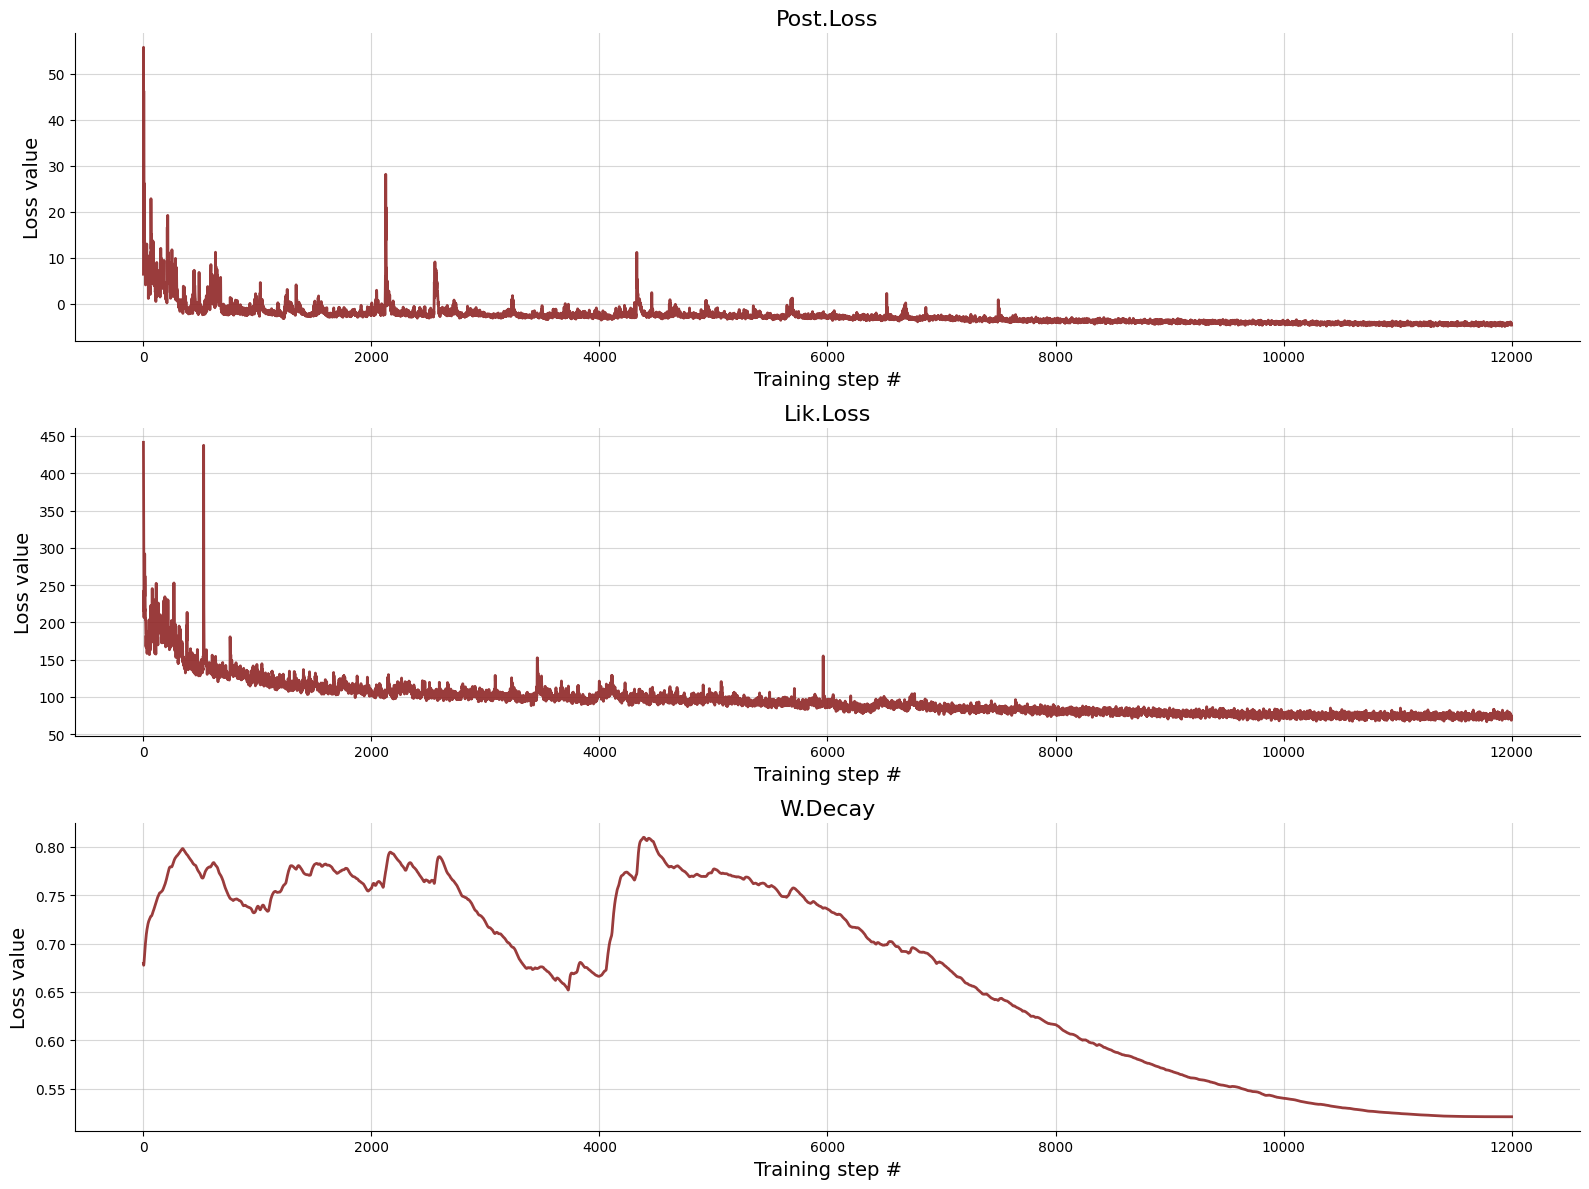

In [97]:
fig = diag.plot_losses(losses)

Validation

In [98]:
valid_data = {}
valid_data['prior_draws'] = np.concatenate((d['Prior'][0:320],d['Prior'][6720:7040]),axis = 0)
valid_data['sim_data'] = np.concatenate((d['Time_Series'][0:320,3,:],d['Time_Series'][6720:7040,3,:]), axis =0)
valid_data['Sampled'] = np.concatenate((d['Time_Series'][0:320,3,a],d['Time_Series'][6720:7040,3,a]), axis =0)

In [134]:
test_dict = {}
test_dict['conditions'] = tf.convert_to_tensor(
    np.divide(valid_data['prior_draws'],mX), dtype=float, dtype_hint=None, name=None
)
test_dict['training'] = 'False'

In [145]:
x_sim_s = amortizer_D.sample_data(test_dict, n_samples=50, to_numpy = True )
x_sim_s = np.squeeze(np.nanmean(x_sim_s,axis=1))
x_sim_s = np.divide(x_sim_s,mY[0,3,0])

In [149]:
# deleting garbage predictions for plot
for sig in x_sim_s:
  for i in range(sig.shape[0]):
    if sig[i] > 4000 or sig[i] < 0:
      sig[i] = 0.5*sig[i-1]+ 0.5*sig[i+1]

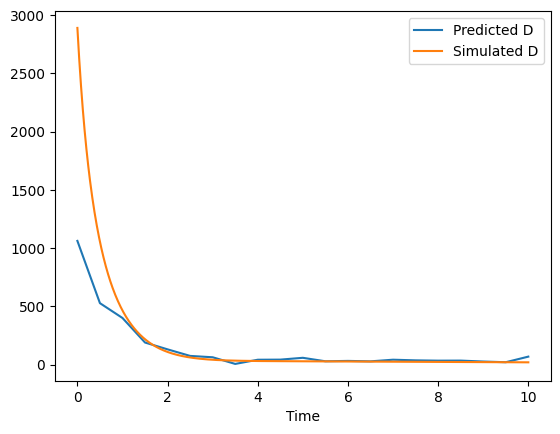

In [137]:
x1 = np.linspace(0, 10, num=1001)
x2 = np.linspace(0, 10, num=21)
plt.plot(x2,x_sim_s[95], label ="Predicted D")
plt.plot(x1,valid_data['sim_data'][95], label = "Simulated D")
#plt.plot(x2,valid_data['Sampled'][95], label = "Sampled from ODE Solution")
#plt.plot(x2,signal.medfilt(x_sim_s[2],7))
plt.xlabel("Time")
#plt.ylabel(" I ")
plt.legend()

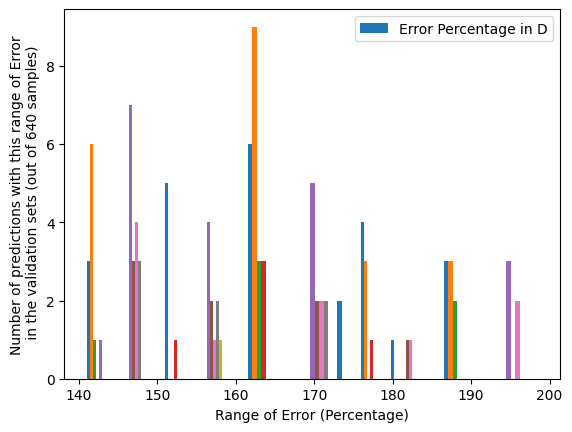

In [138]:
plt.hist((abs((abs(valid_data['Sampled'])-abs(x_sim_s))/(valid_data['Sampled']))*100),bins=[140, 150, 160, 175, 185, 200],label = "Error Percentage in D")
plt.xlabel("Range of Error (Percentage)")
plt.ylabel("Number of predictions with this range of Error\n in the validation sets (out of 640 samples)")
plt.legend()

In [150]:
Accuracy_D = 1-np.mean(abs((valid_data['Sampled']-x_sim_s)/(valid_data['Sampled'])))
print("Accuracy In D =",Accuracy_D)

mean_squared_error(valid_data['Sampled'],x_sim_s)

Accuracy In D = -14701.37021542747


658581559247235.1

# Accuracy and complexity

In [167]:
import time
from sklearn.metrics import mean_squared_error

In [ ]:
#N
valid_data = {}
valid_data['prior_draws'] = np.concatenate((d['Prior'][0:320],d['Prior'][6720:7040]),axis = 0)
valid_data['sim_data'] = np.concatenate((d['Time_Series'][0:320,0,a],d['Time_Series'][6720:7040,0,a]), axis =0)
#valid_data['Sampled'] = np.concatenate((signal.decimate(d['Time_Series'][0:320,0,:],50),signal.decimate(d['Time_Series'][6720:7040,0,:],50)), axis =0)

test_dict = {}
test_dict['conditions'] = tf.convert_to_tensor(
    np.divide(valid_data['prior_draws'],mX), dtype=float, dtype_hint=None, name=None
    )
test_dict['training'] = 'False'
Accu_Comp_N = {}
Accu_Comp_N['T_Exce'] = []
#Accu_Comp_N['Prec'] = []
Accu_Comp_N['Loss'] = []

y_true = valid_data['sim_data']
for i in range(1,50):
  L = []
  prec = []
  Loss = []
  print(i)
  for p in range(5):
    start = time.time()
    y_pred = amortizer.sample_data(test_dict, n_samples=i, to_numpy = True )
    y_pred = np.squeeze(np.nanmean(y_pred,axis = 1))
    y_pred = np.divide(y_pred,mY[0,0,0])
    end = time.time()
    t = end - start
    L.append(t)
    y_pred = np.nan_to_num(y_pred)
    prec.append(np.mean((abs((abs(y_true)-abs(y_pred))/(y_true))*100)))
    Loss.append(mean_squared_error(y_true, y_pred))

  Accu_Comp_N['T_Exce'].append(np.mean(L))
  #Accu_Comp_N['Prec'].append(np.mean(prec))
  Accu_Comp_N['Loss'].append(np.mean(Loss))


In [ ]:
#I
valid_data = {}
valid_data['prior_draws'] = np.concatenate((d['Prior'][0:320],d['Prior'][6720:7040]),axis = 0)
valid_data['sim_data'] = np.concatenate((d['Time_Series'][0:320,1,a],d['Time_Series'][6720:7040,1,a]), axis =0)
#valid_data['Sampled'] = np.concatenate((d['Sampled_Time_Series'][0:320,1,:],d['Sampled_Time_Series'][6720:7040,1,:]), axis =0)

test_dict = {}
test_dict['conditions'] = tf.convert_to_tensor(
    np.divide(valid_data['prior_draws'],mX), dtype=float, dtype_hint=None, name=None
    )
test_dict['training'] = 'False'
Accu_Comp_I = {}
Accu_Comp_I['T_Exce'] = []
#Accu_Comp_I['Prec'] = []
Accu_Comp_I['Loss'] = []

y_true = valid_data['sim_data']
for i in range(1,50):
  L = []
  prec = []
  Loss = []
  print(i)
  for p in range(5):
    start = time.time()
    y_pred = amortizer_I.sample_data(test_dict, n_samples=i, to_numpy = True )
    y_pred = np.squeeze(np.nanmean(y_pred,axis = 1))
    y_pred = np.divide(y_pred,mY[0,1,0])
    end = time.time()
    t = end - start
    L.append(t)
    y_pred = np.nan_to_num(y_pred)
    prec.append(np.mean((abs((abs(y_true)-abs(y_pred))/(y_true))*100)))
    Loss.append(mean_squared_error(y_true, y_pred))

  Accu_Comp_I['T_Exce'].append(np.mean(L))
  #Accu_Comp_I['Prec'].append(np.mean(prec))
  Accu_Comp_I['Loss'].append(np.mean(Loss))

In [ ]:
#E
valid_data = {}
valid_data['prior_draws'] = np.concatenate((d['Prior'][0:320],d['Prior'][6720:7040]),axis = 0)
valid_data['sim_data'] = np.concatenate((d['Time_Series'][0:320,2,a],d['Time_Series'][6720:7040,2,a]), axis =0)
#valid_data['Sampled'] = np.concatenate((d['Sampled_Time_Series'][0:320,2,:],d['Sampled_Time_Series'][6720:7040,2,:]), axis =0)

test_dict = {}
test_dict['conditions'] = tf.convert_to_tensor(
    np.divide(valid_data['prior_draws'],mX), dtype=float, dtype_hint=None, name=None
    )
test_dict['Time_Series'] = 'False'
Accu_Comp_E = {}
Accu_Comp_E['T_Exce'] = []
#Accu_Comp_E['Prec'] = []
Accu_Comp_E['Loss'] = []

y_true = valid_data['sim_data']
for i in range(1,50):
  L = []
  prec = []
  Loss = []
  print(i)
  for p in range(5):
    start = time.time()
    y_pred = amortizer_E.sample_data(test_dict, n_samples=i, to_numpy = True )
    y_pred = np.squeeze(np.nanmean(y_pred,axis = 1))
    y_pred = np.divide(y_pred,mY[0,2,0])
    end = time.time()
    t = end - start
    L.append(t)
    y_pred = np.nan_to_num(y_pred)
    prec.append(np.mean((abs((abs(y_true)-abs(y_pred))/(y_true))*100)))
    Loss.append(mean_squared_error(y_true, y_pred))

  Accu_Comp_E['T_Exce'].append(np.mean(L))
  #Accu_Comp_E['Prec'].append(np.mean(prec))
  Accu_Comp_E['Loss'].append(np.mean(Loss))

In [ ]:
#D
valid_data = {}
valid_data['prior_draws'] = np.concatenate((d['Prior'][0:320],d['Prior'][6720:7040]),axis = 0)
valid_data['sim_data'] = np.concatenate((d['Time_Series'][0:320,3,a],d['Time_Series'][6720:7040,3,a]), axis =0)
#valid_data['Sampled'] = np.concatenate((d['Sampled_Time_Series'][0:320,3,:],d['Sampled_Time_Series'][6720:7040,3,:]), axis =0)

test_dict = {}
test_dict['conditions'] = tf.convert_to_tensor(
    np.divide(valid_data['prior_draws'],mX), dtype=float, dtype_hint=None, name=None
    )
test_dict['training'] = 'False'
Accu_Comp_D = {}
Accu_Comp_D['T_Exce'] = []
#Accu_Comp_D['Prec'] = []
Accu_Comp_D['Loss'] = []

y_true = valid_data['sim_data']
for i in range(1,50):
  L = []
  prec = []
  Loss = []
  print(i)
  for p in range(5):
    start = time.time()
    y_pred = amortizer_D.sample_data(test_dict, n_samples=i, to_numpy = True )
    y_pred = np.squeeze(np.nanmean(y_pred,axis = 1))
    y_pred = np.divide(y_pred,mY[0,3,0])
    end = time.time()
    t = end - start
    L.append(t)
    y_pred = np.nan_to_num(y_pred)
    prec.append(np.mean((abs((abs(y_true)-abs(y_pred))/(y_true))*100)))
    Loss.append(mean_squared_error(y_true, y_pred))

  Accu_Comp_D['T_Exce'].append(np.mean(L))
  #Accu_Comp_D['Prec'].append(np.mean(prec))
  Accu_Comp_D['Loss'].append(np.mean(Loss))

In [172]:
## read dictionary to person_data.pkl file
#with open('/content/drive/MyDrive/Team_Project/Simulated_Data/Accuracy/Accu_Comp_N.pkl', 'rb') as fp:
#    Accu_Comp_N = pickle.load(fp)

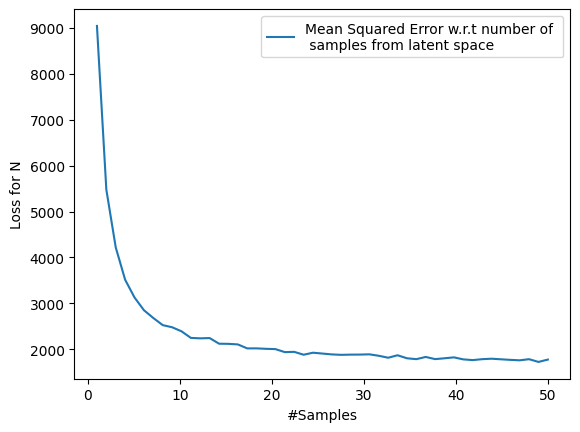

In [230]:
x = np.linspace(1, 50, num = 49)
y2 = Accu_Comp_N['Loss']
y3 = Accu_Comp_N['T_Exce']
plt.plot(x,y2, label = "Mean Squared Error w.r.t number of \n samples from latent space")
plt.xlabel("#Samples")
plt.ylabel("Loss for N")
plt.legend()

In [ ]:
plt.plot(x,y3, label = "Time of execution with respect to number of sampling for N")
plt.xlabel("#Sampling")
plt.ylabel("T_Execution (second)")
plt.legend()

In [175]:
## read dictionary to person_data.pkl file
#with open('/content/drive/MyDrive/Team_Project/Simulated_Data/Accuracy/Accu_Comp_I.pkl', 'rb') as fp:
#    Accu_Comp_I = pickle.load(fp)

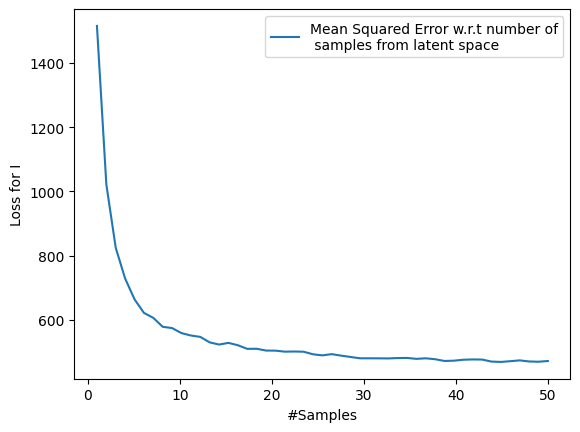

In [229]:
x = np.linspace(1, 50, num = 49)
y2 = Accu_Comp_I['Loss']
y3 = Accu_Comp_I['T_Exce']
plt.plot(x,y2, label = "Mean Squared Error w.r.t number of\n samples from latent space")
plt.xlabel("#Samples")
plt.ylabel("Loss for I")
plt.legend()

In [ ]:
plt.plot(x,y3, label = "Time of execution w.r.t number of sampling for I")
plt.xlabel("#Sampling")
plt.ylabel("T_Execution(second)")
plt.legend()

In [178]:
## read dictionary to person_data.pkl file
#with open('/content/drive/MyDrive/Team_Project/Simulated_Data/Accuracy/Accu_Comp_E.pkl', 'rb') as fp:
#    Accu_Comp_E = pickle.load(fp)

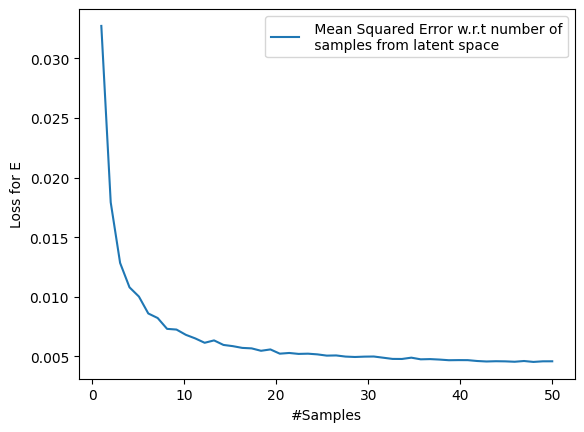

In [231]:
x = np.linspace(1, 50, num = 49)
y2 = Accu_Comp_E['Loss']
y3 = Accu_Comp_E['T_Exce']
plt.plot(x,y2, label = " Mean Squared Error w.r.t number of\n samples from latent space")
plt.xlabel("#Samples")
plt.ylabel("Loss for E")
plt.legend()

In [ ]:
plt.plot(x,y3, label = "Time of execution w.r.t number of sampling for E")
plt.xlabel("#Sampling")
plt.ylabel("T_Execution(second)")
plt.legend()

In [181]:
## read dictionary to person_data.pkl file
#with open('/content/drive/MyDrive/Team_Project/Simulated_Data/Accuracy/Accu_Comp_D.pkl', 'rb') as fp:
#    Accu_Comp_D = pickle.load(fp)

In [ ]:
for i in range(len(Accu_Comp_D['Loss'])):
  print(i)
  if Accu_Comp_D['Loss'][i] > 1000000000:
    Accu_Comp_D['Loss'][i] = 0.5*Accu_Comp_D['Loss'][i-1]

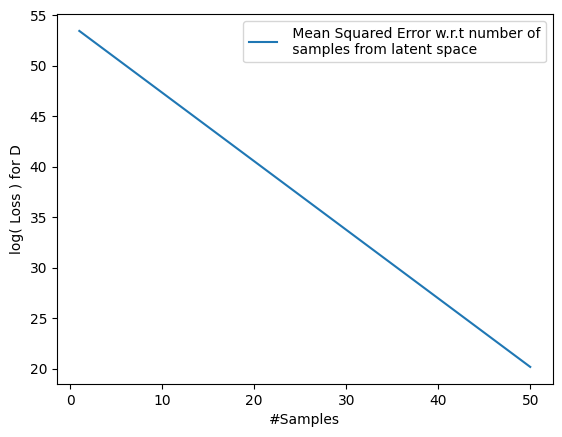

In [232]:
x = np.linspace(1, 50, num = 49)
y2 = np.log(Accu_Comp_D['Loss'])
y3 = Accu_Comp_D['T_Exce']
plt.plot(x,y2, label = " Mean Squared Error w.r.t number of\n samples from latent space")
plt.xlabel("#Samples")
plt.ylabel("log( Loss ) for D")
plt.legend()

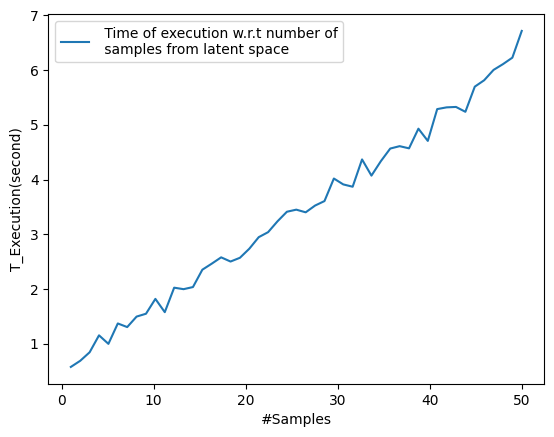

In [233]:
plt.plot(x,y3, label = " Time of execution w.r.t number of\n samples from latent space")
plt.xlabel("#Samples")
plt.ylabel("T_Execution(second)")
plt.legend()

# Saving the results

In [ ]:
# save dictionary to person_data.pkl file
with open('/content/drive/MyDrive/Team_Project/Simulated_Data/Accu_Comp_N.pkl', 'wb') as fp:
    pickle.dump(Accu_Comp_N, fp)

In [ ]:
with open('/content/drive/MyDrive/Team_Project/Simulated_Data/Accu_Comp_I.pkl', 'wb') as fp:
    pickle.dump(Accu_Comp_I, fp)

In [ ]:
with open('/content/drive/MyDrive/Team_Project/Simulated_Data/Accu_Comp_E.pkl', 'wb') as fp:
    pickle.dump(Accu_Comp_E, fp)

In [ ]:
with open('/content/drive/MyDrive/Team_Project/Simulated_Data/Accu_Comp_D.pkl', 'wb') as fp:
    pickle.dump(Accu_Comp_D, fp)

# Test for 1 Cell

In [118]:
N_ext = 1700
D_ext = 2700
Initial = [N_ext, D_ext, 1000 , 3, 2, 450]

In [119]:
def prior_sample_test(Initial):

    N_ext = Initial[0]
    D_ext = Initial[1]
    N_0 = Initial[2]
    I_0 = Initial[3]
    E_0 = Initial[4]
    D_0 = Initial[5]
    params = np.array([N_ext, D_ext, N_0, I_0, E_0, D_0])
    params = np.reshape(params,(1,6))
    return np.ceil(params)

In [120]:
def ode_system(t, y, D_ext, N_ext, p, kc, kt, gamma, gamma_I, N0, I0, E0, D0):
  N,I,E,D = y
  Nt_dt = (N0 * (1+(I**p/(I0**p+I**p)))) - (kc * N * D) - (kt * N * D_ext) - gamma * N
  It_dt = (kt * N * D_ext) - (gamma_I * I)
  Et_dt = (1 * (I**p/(I0**p+I**p))) - (gamma * E)
  Dt_dt = (D0 * (I0**p/(I0**p+I**p))) - (kc*N*D) - (kt * N_ext * D) - (gamma * D)
  return [Nt_dt, It_dt, Et_dt, Dt_dt]

In [121]:
def Nonlinear_Solver(params, T, p = 2,
                     kc = 5.e-4,kt = 5.e-5,
                     gamma = 0.1,gamma_I = 0.5,
                     N0 = 500,I0 = 200, E0 = 1, D0 = 1000,
                     scale_I = 100, scale_N = 1000, scale_E = 0.25, scale_D = 3000):
  """Performs a forward simulation with LSODA method using solve_ivp for the Nonlinear ODE model given a random draw from the prior,"""
  # Extract parameters
  N_ext = params[0]
  D_ext = params[1]
  # Initial conditions
  initial_cond = [params[2],params[3],params[4],params[5]]
  # Simulate T+1 timesteps
  time = (0,T)
  solution = solve_ivp(ode_system,time, initial_cond, method='LSODA', args=(D_ext, N_ext, p, kc, kt, gamma, gamma_I, N0, I0, E0, D0),max_step=0.01)
  t = solution.t
  N_sol, I_sol, E_sol, D_sol = solution.y
  #return np.stack([N_sol/scale_N, I_sol/scale_I, E_sol/scale_E, D_sol/scale_D])
  return np.stack([N_sol, I_sol, E_sol, D_sol])

In [122]:
T = 6

Real_Time_Series = Nonlinear_Solver(prior_sample_test(Initial)[0],60)

In [124]:
# N
prior = prior_sample_test(Initial)
sig = np.zeros((1,T*21))
for i in range(T):
  test_dict = {}
  test_dict['conditions'] = tf.convert_to_tensor(
      np.divide(prior,mX), dtype=float, dtype_hint=None, name=None
  )
  test_dict['training'] = 'False'
  x_sim_s = amortizer.sample_data(test_dict, n_samples=10, to_numpy = True )
  x_sim_s = np.nan_to_num(x_sim_s)
  x_sim_s = np.squeeze(np.mean(x_sim_s,axis = 0))
  x_sim_s = np.divide(x_sim_s,mY[0,0,0])
  sig[0:1,i*21:(i+1)*21] = x_sim_s
  prior = prior_sample_test(x_sim_s)

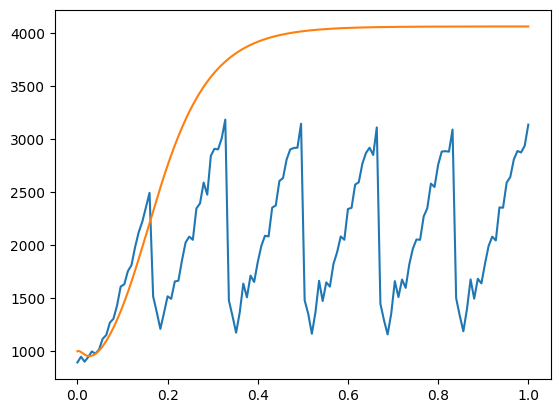

In [126]:
#N
x1 = np.linspace(0, 1, num=T*21)
x2 = np.linspace(0, 1, num=Real_Time_Series.shape[1])

predict = sig


plt.plot(x1,predict[0,:] , label = "Predicted")
plt.plot(x2,Real_Time_Series[0,:] , label = "Simulated")

In [127]:
# I
prior = prior_sample_test(Initial)
sig = np.zeros((1,T*21))
for i in range(T):
  test_dict = {}
  test_dict['conditions'] = tf.convert_to_tensor(
      np.divide(prior,mX), dtype=float, dtype_hint=None, name=None
  )
  test_dict['training'] = 'False'
  x_sim_s = amortizer_I.sample_data(test_dict, n_samples=10, to_numpy = True )
  x_sim_s = np.nan_to_num(x_sim_s)
  x_sim_s = np.squeeze(np.mean(x_sim_s,axis = 0))
  x_sim_s = np.divide(x_sim_s,mY[0,1,0])
  sig[0:1,i*21:(i+1)*21] = x_sim_s
  prior = prior_sample_test(x_sim_s)

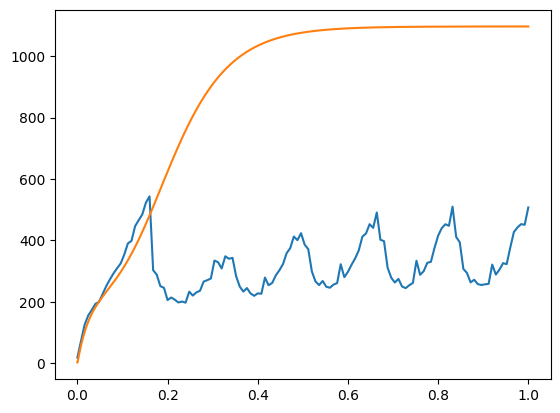

In [128]:
#I
x1 = np.linspace(0, 1, num=T*21)
x2 = np.linspace(0, 1, num=Real_Time_Series.shape[1])

predict = sig


plt.plot(x1,predict[0,:] , label = "Predicted")
plt.plot(x2,Real_Time_Series[1,:] , label = "Simulated")

In [129]:
# E
prior = prior_sample_test(Initial)
sig = np.zeros((1,T*21))
for i in range(T):
  test_dict = {}
  test_dict['conditions'] = tf.convert_to_tensor(
      np.divide(prior,mX), dtype=float, dtype_hint=None, name=None
  )
  test_dict['training'] = 'False'
  x_sim_s = amortizer_E.sample_data(test_dict, n_samples=10, to_numpy = True )
  x_sim_s = np.nan_to_num(x_sim_s)
  x_sim_s = np.squeeze(np.mean(x_sim_s,axis = 0))
  x_sim_s = np.divide(x_sim_s,mY[0,2,0])
  sig[0:1,i*21:(i+1)*21] = x_sim_s
  prior = prior_sample_test(x_sim_s)

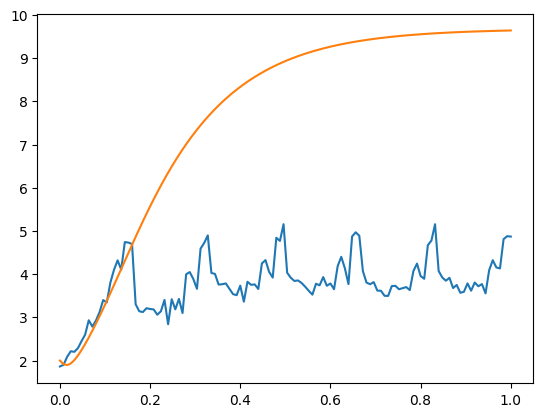

In [130]:
#E
x1 = np.linspace(0, 1, num=T*21)
x2 = np.linspace(0, 1, num=Real_Time_Series.shape[1])

predict = sig


plt.plot(x1,predict[0,:] , label = "Predicted")
plt.plot(x2,Real_Time_Series[2,:] , label = "Simulated")

In [131]:
# D
prior = prior_sample_test(Initial)
sig = np.zeros((1,T*21))
for i in range(T):
  test_dict = {}
  test_dict['conditions'] = tf.convert_to_tensor(
      np.divide(prior,mX), dtype=float, dtype_hint=None, name=None
  )
  test_dict['training'] = 'False'
  x_sim_s = amortizer_D.sample_data(test_dict, n_samples=10, to_numpy = True )
  x_sim_s = np.nan_to_num(x_sim_s)
  x_sim_s = np.squeeze(np.mean(x_sim_s,axis = 0))
  x_sim_s = np.divide(x_sim_s,mY[0,3,0])
  sig[0:1,i*21:(i+1)*21] = x_sim_s
  prior = prior_sample_test(x_sim_s)

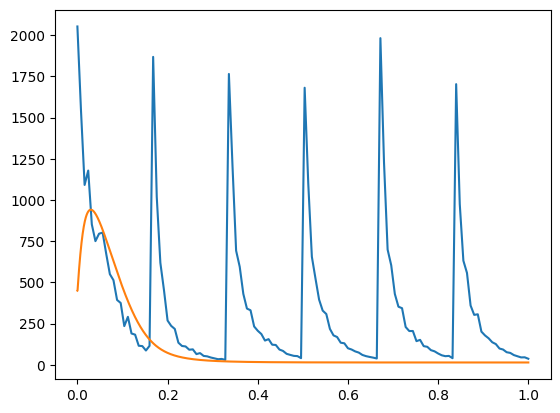

In [132]:
x1 = np.linspace(0, 1, num=T*21)
x2 = np.linspace(0, 1, num=Real_Time_Series.shape[1])

predict = sig


plt.plot(x1,predict[0,:] , label = "Predicted")
plt.plot(x2,Real_Time_Series[3,:] , label = "Simulated")